In [27]:
import os
import datetime
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D, ZeroPadding2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [28]:
# removing duplicate images from same lesion

df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')
# if your image names have no extension
df['image_id'] = df['image_id'].astype(str) + '.jpg'

df=df.drop(['image_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels = df['dx'].unique() # 7 labels
labels = list(labels)
labels.sort()
print(labels)
df.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
# how many images are there for each labels
lesion_counts = []
df_lesion = df['dx'].sort_values()
for label in labels:
    lesion_counts += [len(df[df['dx'] == label])]
    #print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
print(lesion_counts)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[151, 175, 440, 39, 230, 4415, 64]


In [29]:
# Same for test set

df_test=pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
# if your image names have no extension
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

df_test=df_test.drop(['image_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels_test = df_test['dx'].unique() # 7 labels_test
labels_test = list(labels_test)
labels_test.sort()
print(labels_test)
df_test.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
# how many images are there for each labels_test
lesion_counts_test = []
df_test_lesion = df_test['dx'].sort_values()
for label in labels_test:
    lesion_counts_test += [len(df_test[df_test['dx'] == label])]
    #print("There are " + str(len(df_test[df_test['dx'] == label])) + " images belong to " + label + " label")
print(lesion_counts_test)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[21, 56, 132, 37, 60, 665, 26]


In [30]:
df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')
# if your image names have no extension
df['image_id'] = df['image_id'].astype(str) + '.jpg'

df=df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels = df['dx'].unique() # 7 labels
labels = list(labels)
labels.sort()
print(labels)
# how many images are there for each labels
image_counts = []
df_image = df['dx'].sort_values()
for label in labels:
    image_counts += [len(df[df['dx'] == label])]
    #print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
print(image_counts)


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[327, 514, 1099, 115, 1113, 6705, 142]


In [31]:
# Same for test 
df_test=pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
# if your image names have no extension
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

df_test=df_test.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels_test = df_test['dx'].unique() # 7 labels_test
labels_test = list(labels_test)
labels_test.sort()
print(labels_test)
# how many images are there for each labels_test
image_counts_test = []
df_test_image = df_test['dx'].sort_values()
for label in labels_test:
    image_counts_test += [len(df_test[df_test['dx'] == label])]
    #print("There are " + str(len(df_test[df_test['dx'] == label])) + " images belong to " + label + " label")
print(image_counts_test)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[43, 93, 217, 44, 171, 909, 35]


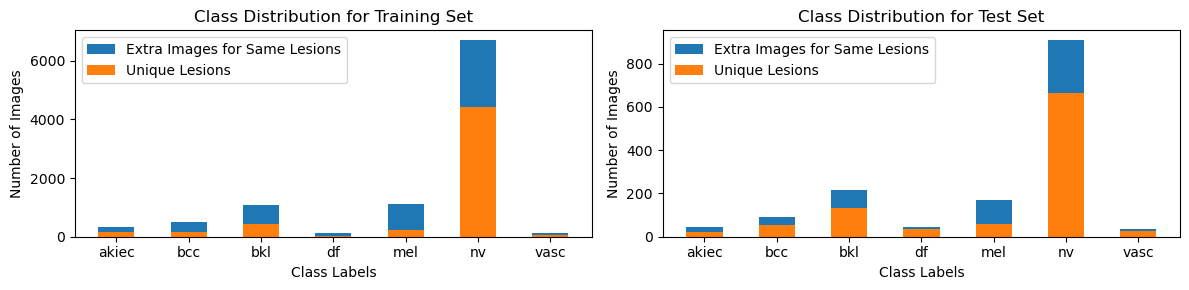

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set

ax1.hist(df_image.values, bins=bins)
ax1.hist(df_lesion.values, bins=bins)
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')
ax1.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

# Plotting class distribution  for test set
ax2.hist(df_test_image.values, bins=bins)
ax2.hist(df_test_lesion.values, bins=bins)
ax2.set_title("Class Distribution for Test Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')
ax2.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()


In [33]:
'''
random.seed(42)
np.random.seed(42)
np.random.RandomState(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
'''

"\nrandom.seed(42)\nnp.random.seed(42)\nnp.random.RandomState(42)\ntf.random.set_seed(42)\nos.environ['TF_DETERMINISTIC_OPS'] = '1'\n"

In [34]:
# np.random.seed(42)
# grouped = df.groupby('dx')
# for label in labels:
#     drop_indices = []
#     if grouped.get_group(label).shape[0] > 1000:
#         remove_n = grouped.get_group(label).shape[0] - 1000 # number of images in the smallest class
#         drop_indices = np.random.choice(grouped.get_group(label).index, remove_n, replace=False)
#         df = df.drop(drop_indices) # drop extra images from original dataset

In [35]:
# 'ISIC_0035068.jpg' is missing in the dataset, lets remove it from test set
df_test = df_test[df_test['image_id'] != 'ISIC_0035068.jpg']

print(labels,'\n')

df.sort_values(by=['image_id'], inplace=True)
df.reset_index(inplace=True, drop=True)
df_test.sort_values(by=['image_id'], inplace=True)
df_test.reset_index(inplace=True, drop=True)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 



In [36]:
train_df, val_df=train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx']) 
test_df = df_test.copy().sample(frac=1, random_state=123).reset_index(drop=True) # shuffle test set
for label in labels:
    list1 = len(train_df[train_df['dx'] == label]), len(val_df[val_df['dx'] == label]), len(test_df[test_df['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
    
train_df.shape, val_df.shape, test_df.shape

akiec  (294, 33, 43)
bcc    (463, 51, 93)
bkl    (989, 110, 217)
df     (103, 12, 44)
mel    (1002, 111, 171)
nv     (6034, 671, 908)
vasc   (128, 14, 35)


((9013, 2), (1002, 2), (1511, 2))

In [37]:
# Save splitted dataframes to csv
train_df.to_csv('dataverse_files/train_split.csv', index=False)
val_df.to_csv('dataverse_files/val_split.csv', index=False)
test_df.to_csv('dataverse_files/test_split.csv', index=False)

# Read splitted dataframes from csv
train_df=pd.read_csv('dataverse_files/train_split.csv')
val_df=pd.read_csv('dataverse_files/val_split.csv')
test_df=pd.read_csv('dataverse_files/test_split.csv')

In [38]:
rescale=1./255
color_mode = 'rgb'
target_size = (28, 28)
batch_size  = 32
# 600 x 450

train_datagen = ImageDataGenerator(rescale=rescale)
train_set = train_datagen.flow_from_dataframe(train_df,
                                              directory="dataverse_files/HAM10000_images",
                                              x_col="image_id",
                                              y_col="dx",
                                              color_mode=color_mode,
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False
                                              )
val_datagen = ImageDataGenerator(rescale=rescale)
val_set = val_datagen.flow_from_dataframe(val_df,
                                          directory="dataverse_files/HAM10000_images",
                                          x_col="image_id",
                                          y_col="dx",
                                          color_mode=color_mode,
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False
                                          )
test_datagen = ImageDataGenerator(rescale=rescale)
test_set = test_datagen.flow_from_dataframe(test_df,
                                            directory="dataverse_files/ISIC2018_Task3_Test_Images",
                                            x_col="image_id",
                                            y_col="dx",
                                            color_mode=color_mode,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False
                                            )

Found 9013 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.


In [14]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(filters=32, 
                 kernel_size=(3,3), 
                 activation='relu', 
                 input_shape=(target_size[0],target_size[1],3)
                 ))

model.add(MaxPooling2D(pool_size = (3,3)))
model.add(BatchNormalization())

#2nd CNN layer
model.add(Conv2D(filters=64, 
                 kernel_size=(5,5), 
                 activation='relu',
                ))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(BatchNormalization())

# Passing it to a Fully Connected layer
model.add(Flatten())

#1st Fully Connected layer
model.add(Dense(64, activation='relu'))

#2nd Fully Connected layer
model.add(Dense(32, activation='relu'))


#Last Layer
model.add(Dense(no_of_classes, activation='softmax'))


#model.add(Dropout(0.25))

model.compile(optimizer=Adam(learning_rate = 0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'],
              )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 32)         128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                        

In [16]:
now = datetime.datetime.now().strftime("%d-%m-%H-%M")
os.system(f"mkdir -p model-comparison/{now}")

checkpoint = ModelCheckpoint(f"model-comparison/{now}/model.h5", monitor='val_accuracy', 
                             verbose=0, save_best_only=True, mode='max')
history = model.fit(train_set,
                    #steps_per_epoch=50,
                    epochs=15,
                    validation_data = val_set,
                    #validation_steps = 15,
                    callbacks=[checkpoint],
                    verbose=1,
                    )

Epoch 1/15


2023-11-21 19:49:34.826711: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


116/116 [==============================] - 13s 113ms/step - loss: 1.3920 - accuracy: 0.4759 - val_loss: 2.1412 - val_accuracy: 0.1905
Epoch 2/15
116/116 [==============================] - 13s 111ms/step - loss: 1.1290 - accuracy: 0.5667 - val_loss: 2.6021 - val_accuracy: 0.1667
Epoch 3/15
116/116 [==============================] - 13s 110ms/step - loss: 1.0147 - accuracy: 0.6036 - val_loss: 2.1740 - val_accuracy: 0.2143
Epoch 4/15
116/116 [==============================] - 13s 112ms/step - loss: 0.9398 - accuracy: 0.6399 - val_loss: 1.9436 - val_accuracy: 0.2738
Epoch 5/15
116/116 [==============================] - 13s 112ms/step - loss: 0.8427 - accuracy: 0.6803 - val_loss: 2.8864 - val_accuracy: 0.2143
Epoch 6/15
116/116 [==============================] - 13s 112ms/step - loss: 0.7766 - accuracy: 0.7077 - val_loss: 1.9542 - val_accuracy: 0.3571
Epoch 7/15
116/116 [==============================] - 13s 112ms/step - loss: 0.6886 - accuracy: 0.7419 - val_loss: 1.7505 - val_accuracy: 0.3

In [17]:
with open('model-comparison/last.txt', 'w') as f:
    f.write(str(now))

model.save(f"model-comparison/{now}/model.h5")

# convert the history.history dict to a pandas DataFrame:
if type(history) is not pd.DataFrame:
    history = pd.DataFrame(history.history) 

# save to csv: 
hist_csv_file = f'model-comparison/{now}/history.csv'
with open(hist_csv_file, mode='w') as f:
    history.to_csv(f)

In [13]:
# read last model variable from txt file
now = open('model-comparison/last.txt', 'r').read() 
#now = '04-11-22-13'
model = load_model(f"model-comparison/{now}/model.h5")
history = pd.read_csv(f'model-comparison/{now}/history.csv')

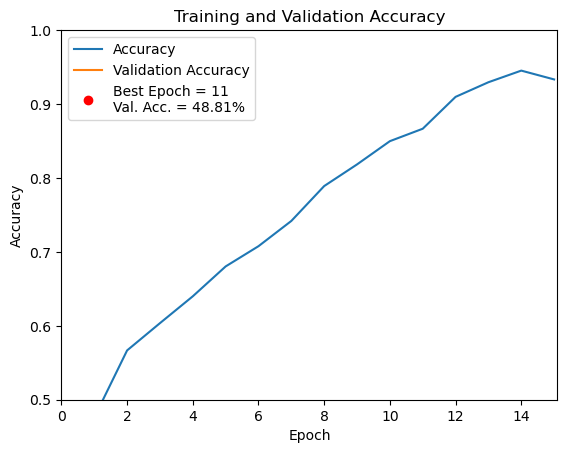

In [18]:
epochs = range(1, history.shape[0]+1)
plt.plot(epochs, history['accuracy'], label='Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
max_val_acc_epoch = np.argmax(history['val_accuracy']) + 1
max_val_acc = history['val_accuracy'][max_val_acc_epoch-1]
label='Best Epoch = '+str(max_val_acc_epoch)+'\nVal. Acc. = '+str((max_val_acc*100).round(2))+ '%'
plt.plot(max_val_acc_epoch, max_val_acc, 'ro', label=label)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([0, history.shape[0]+0.1])
plt.ylim([0.5, 1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='upper left')

plt.savefig(f'model-comparison/{now}/val-acc.png')

In [20]:
def EvaluateModel(model, test_set, str1, now):
    
    tf.random.set_seed(42)
    print('\n PREDICTING LABELS OF TEST IMAGES')
    result = model.predict(test_set)
    y_pred = np.argmax(result, axis=1)
    #save y_pred to csv file
    os.system("mkdir -p model-comparison/{}/{}".format(now,str1))
    
    np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
    
    y_true = test_set.classes # List containing true labels for each image.

    # Understanding classification power of model on each class    
    report = classification_report(y_true, y_pred, target_names=test_set.class_indices.keys())
    report_d = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=test_set.class_indices.keys())).transpose()
    report_d['support']['accuracy'] = report_d['support']['macro avg']

    annot = report_d.copy()
    annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
    annot.iloc[7, 1] = ''
    annot.iloc[7, 0] = ''
    annot['support'] = annot['support'].astype(int)

    # how to save report as image
    norm = Normalize(-1,1)
    cmap = LinearSegmentedColormap.from_list("", [[norm(-1.0), "white"],[norm( 1.0), "white"]])
    plot = sns.heatmap(report_d, annot=annot, cmap=cmap, cbar=False, fmt='')
    fig = plot.get_figure()
    fig.savefig('model-comparison/{}/{}/report.png'.format(now,str1))
    
    f1_score = ((report_d['f1-score']['weighted avg']*100000//10)/100)
    accuracy = ((report_d['f1-score']['accuracy']*100000//10)/100)
    print('\nF1-score of model prediction is: {:.2f} %'.format(accuracy))
    print('\nAccuracy of model prediction is: {:.2f} %'.format(f1_score))

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_set.class_indices.keys()
                              )
    disp.plot(cmap='Reds')
    disp.ax_.set_title('Confusion Matrix')
    disp.figure_.savefig('model-comparison/{}/{}/cm.png'.format(now,str1))


 PREDICTING LABELS OF TEST IMAGES
3/3 [==============================] - 0s 92ms/step

F1-score of model prediction is: 27.38 %

Accuracy of model prediction is: 25.17 %


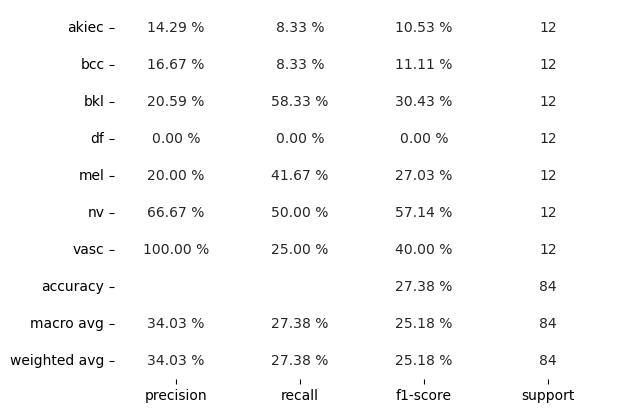

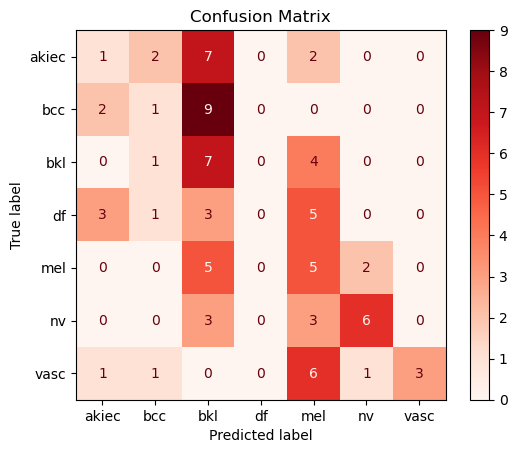

In [21]:
EvaluateModel(model, val_set, 'val', now)


 PREDICTING LABELS OF TEST IMAGES
48/48 [==============================] - 5s 110ms/step

F1-score of model prediction is: 44.34 %

Accuracy of model prediction is: 47.92 %


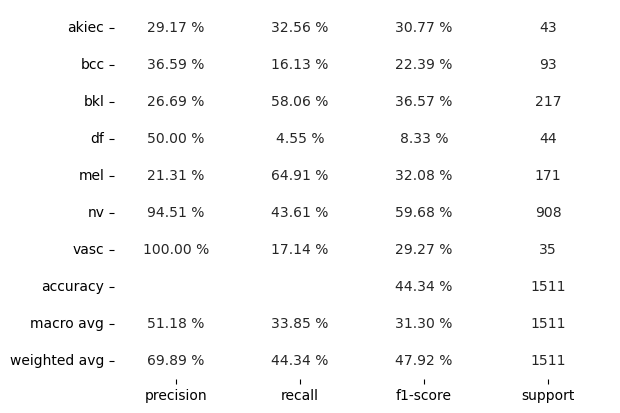

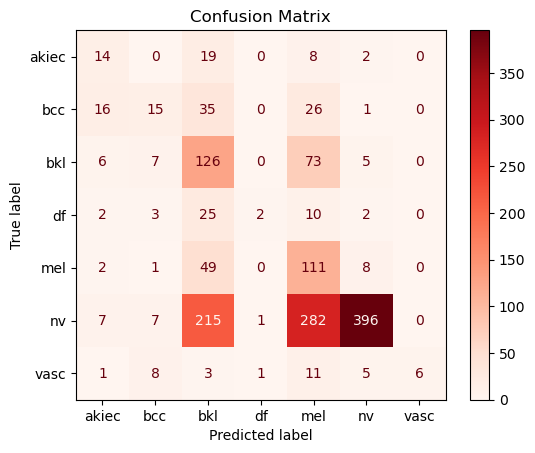

In [22]:
EvaluateModel(model, test_set, 'test', now)